## Use NLCD to assign Manning's $n$ to Matanzas model grid

### Import required Python packages

In [1]:
import datetime
import numpy as np
# import pandas as pd
# import rasterio # rasterio and OGR don't mix...see rasterio docs
import matplotlib.pyplot as plt
import xarray as xr
import scipy.io as sio
# import scipy.signal
from pyproj import Proj, transform
from scipy import interpolate
%matplotlib inline

### Location and name of the model grid

In [2]:
#gdir = '../../Matanzas_grid/'
gdir = './'
gfn  = 'GTM_COARSE_May12018_smooth_open_s.nc'

### Import model grid

In [3]:
# Import COAWST grid
dsc = xr.open_dataset(gdir+gfn)

### Display contents of grid

In [4]:
dsc

<xarray.Dataset>
Dimensions:    (bath: 1, eta_psi: 822, eta_rho: 823, eta_u: 823, eta_v: 822, one: 1, xi_psi: 549, xi_rho: 550, xi_u: 549, xi_v: 550)
Dimensions without coordinates: bath, eta_psi, eta_rho, eta_u, eta_v, one, xi_psi, xi_rho, xi_u, xi_v
Data variables:
    xl         (one) float64 ...
    el         (one) float64 ...
    JPRJ       |S2 ...
    spherical  (one) |S1 ...
    depthmin   (one) int16 ...
    depthmax   (one) int16 ...
    hraw       (bath, eta_rho, xi_rho) float64 ...
    h          (eta_rho, xi_rho) float64 ...
    f          (eta_rho, xi_rho) float64 ...
    pm         (eta_rho, xi_rho) float64 ...
    pn         (eta_rho, xi_rho) float64 ...
    dndx       (eta_rho, xi_rho) float64 ...
    dmde       (eta_rho, xi_rho) float64 ...
    x_rho      (eta_rho, xi_rho) float64 ...
    y_rho      (eta_rho, xi_rho) float64 ...
    x_psi      (eta_psi, xi_psi) float64 ...
    y_psi      (eta_psi, xi_psi) float64 ...
    x_u        (eta_u, xi_u) float64 ...
    y_u   

### Visualize grid by plotting depth

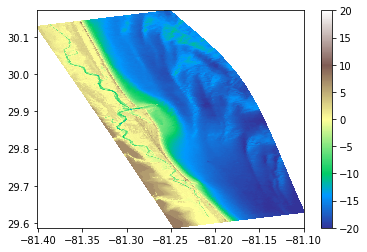

In [5]:
plt.pcolormesh(dsc.lon_rho.values, dsc.lat_rho.values, -dsc.h.values,cmap=plt.cm.terrain,vmin=-20,vmax=20)
plt.colorbar()

### Import the 2011 National Landcover Database from Rich Signell's public Amazon S3 bucket

In [6]:
fname = "https://rsignell.s3.amazonaws.com/NLCD/nlcd_2011_landcover_2011_edition_2014_10_10.tif"
ds = xr.open_rasterio(fname, chunks={'x':256, 'y':256})
ds

<xarray.DataArray (band: 1, y: 104424, x: 161190)>
dask.array<shape=(1, 104424, 161190), dtype=uint8, chunksize=(1, 256, 256)>
Coordinates:
  * band     (band) int32 1
  * y        (y) float64 3.31e+06 3.31e+06 3.31e+06 3.31e+06 3.31e+06 ...
  * x        (x) float64 -2.493e+06 -2.493e+06 -2.493e+06 -2.493e+06 ...
Attributes:
    transform:   (30.0, 0.0, -2493045.0, 0.0, -30.0, 3310005.0, 0.0, 0.0, 1.0)
    crs:         +ellps=GRS80 +lat_0=23 +lat_1=29.5 +lat_2=45.5 +lon_0=-96 +n...
    res:         (30.0, 30.0)
    is_tiled:    1
    nodatavals:  (nan,)

In [7]:
# find boundaries of model grid
lat_min, lat_max = np.min(dsc.lat_rho.values), np.max(dsc.lat_rho.values)
lon_min, lon_max = np.min(dsc.lon_rho.values), np.max(dsc.lon_rho.values)
print('Grid boundaries: ',lat_min, lat_max, lon_min, lon_max)

# specify projections
llProj = Proj(init='epsg:4326') # WGS84 lat/lon
aeProj = Proj(ds.crs)           # NLCD projection (Albers equal area)

# translate grid corners to Albers projection
e0,n0 = transform(llProj,aeProj,lon_min, lat_max) # Upper left bounding corner
e1,n1 = transform(llProj,aeProj,lon_max, lat_min) # Lower right bounding corner
print('Grid boundaries in NLCD coordinates: ',e0,n0,e1,n1)
print('E-W extent: ',e1-e0,' N-S extent', n0-n1)

Grid boundaries:  29.5866702772 30.1719832845 -81.4016007218 -81.0990831436
Grid boundaries in NLCD coordinates:  1398586.0976788567 896096.3395075956 1437473.0227592518 836455.6007722215
E-W extent:  38886.92508039507  N-S extent 59640.73873537418


### Grab a subset of the NLCD database and plot

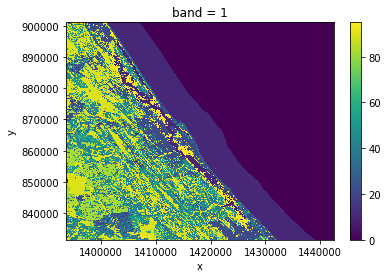

In [8]:
# pad this by 5 km
dss = ds[0,:,:].sel(x=slice(e0-5000.,e1+5000.), y=slice(n0+5000.,n1-5000))
dss.plot.imshow()

### Lookup table for converting NLCD to Manning's $n$
These are from

Mattocks, C., Forbes, C., 2008. A real-time, event-triggered storm surge forecasting system for the state of North Carolina. Ocean Modelling 25, 95–119. https://doi.org/10.1016/j.ocemod.2008.06.008.

See also https://github.com/csherwood-usgs/NLCD_to_Roughness/blob/master/NLCD_to_Roughness.ipynb

In [9]:
n = {11:0.02, 12:0.10, 21:0.02, 22:0.05, 23:0.10, 24:0.15,\
     31:0.09, 32:0.04, 41:0.10, 42:0.11, 43:0.10, 51:0.04,\
     52:0.05, 71:0.034, 72:0.03, 73:0.027, 74:0.025, 81:0.033,\
     82:0.037, 90:0.10, 91:0.10, 92:0.048, 93:0.10, 94:0.048,\
     95:0.045, 96:0.045, 97:0.045, 98:0.015, 99:0.015,\
     0:0.02}

In [10]:
### Apply that to the NLCLD database
# Make an array of NLCD land cover indices from the DataArray
lci = dss.values

# initialize a float array with same shape as the NLCD array# initi 
nmap = 0.0*np.ones_like(lci[:,:])
(ni,nj)=np.shape(lci[:,:])
print('Shapes of new np array and DataArray: ',np.shape(lci[:,:]),np.shape(nmap))
print('Print number of rows, columns: ',ni,nj)

# loop through and assign Manning's n value to array using class look-up table
for i in range(ni):
    for j in range(nj):
        nmap[i,j]=n[lci[i,j]]
print('\nRoughness values:')
nmap

Shapes of new np array and DataArray:  (2321, 1630) (2321, 1630)
Print number of rows, columns:  2321 1630

Roughness values:


array([[ 0.11 ,  0.11 ,  0.1  , ...,  0.02 ,  0.02 ,  0.02 ],
       [ 0.045,  0.11 ,  0.1  , ...,  0.02 ,  0.02 ,  0.02 ],
       [ 0.045,  0.11 ,  0.11 , ...,  0.02 ,  0.02 ,  0.02 ],
       ..., 
       [ 0.1  ,  0.11 ,  0.1  , ...,  0.02 ,  0.02 ,  0.02 ],
       [ 0.1  ,  0.1  ,  0.11 , ...,  0.02 ,  0.02 ,  0.02 ],
       [ 0.1  ,  0.1  ,  0.1  , ...,  0.02 ,  0.02 ,  0.02 ]])

Shape of xx:  (2321, 1630)
Shape of nmap: (2321, 1630)


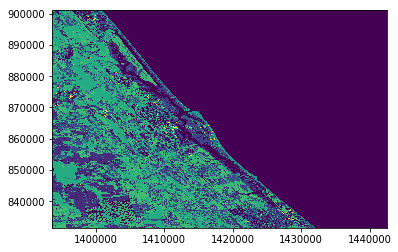

In [11]:
# make same-sized arrays of x and y (these are in the Albers projection)
x = dss['x'].values
y = dss['y'].values

# the interpolation scheme wants ascending values...y starts in the upper left and descends, so flip it...
y = np.flip(y,0)
xx,yy = np.meshgrid(x,y)
print('Shape of xx: ',np.shape(xx))

# ...and flip the data grid too
nmap = np.flipud(nmap)
print('Shape of nmap:',np.shape(nmap))
# look at the roughness map
plt.pcolormesh(xx,yy,nmap)

### Define the interpolation function

Depending on the resolution of the model grid v. the NLCD grid, we may want to smooth the NLCD roughness first
That is not done here.

In [12]:
# Both of these whine about the fact that y decreases, rather than increases...so y and nmap have been flipped
f=interpolate.RegularGridInterpolator((y,x), nmap, method='nearest')

In [13]:
# lon_rho and lat_rho are the locations we would like roughness values
etc,ntc = transform(llProj,aeProj,dsc.lon_rho.values,dsc.lat_rho.values)
# we keep getting interpolation errors...what is the range of values we are interpolating?
print(np.min(etc),np.max(etc),np.min(ntc),np.max(ntc))
print(np.min(x),np.max(x), np.min(y),np.max(y))

1399321.94791 1436742.0217 834239.32654 898325.633661
1393590.0 1442460.0 831480.0 901080.0


### Interpolate from NLCD to model grid

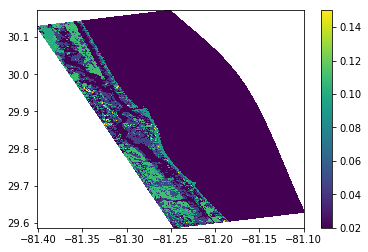

In [14]:
cnmapi = f((ntc,etc))
# look at the roughness map
plt.pcolormesh(dsc.lon_rho.values,dsc.lat_rho.values,cnmapi)
plt.colorbar()

### Last step is to add the roughness values to the model grid and save the grid

In [15]:
# make a copy of the model grid dataset
dsc2 = dsc.copy()
# make a new variable by copying h
dsc2['n']=dsc2['h']

# assign values of Manning's n to variable n
dsc2['n'].values=cnmapi

# modify the global attribute for file history
dsc2.attrs['history'] = dsc.attrs['history']+' with Mannings n added by Matanzas.ipynb on '+str(datetime.datetime.now())

print("netcdf history attribute: \n",dsc2.attrs['history'])

# save as ROMS netcdf grid.
dsc2.to_netcdf('GTM_COARSE_May12018_smooth_open_s_manningsn.nc',mode='w')

netcdf history attribute: 
 Created by create_roms_netcdf_grid_file, on 03-Dec-2017 14:19:59 with Mannings n added by Matanzas.ipynb on 2018-08-29 13:27:51.851573


### Experiment with converting Manning's $n$ to drag coefficient cd
I suspect you will want to tweak the final cd values to limit the range

In [16]:
# copy grid depth array
hadj = dsc.h.values
# assign all negative values (land) depth of 1 m
hadj[hadj<=0.]=1.0
# calculate cd from Manning's n (might want to revist this)
cd = 9.81*cnmapi**2./(hadj**(1./3.))
print("Min, Mean, and Max. cd: ",np.min(cd),np.mean(cd),np.max(cd))

Min, Mean, and Max. cd:  0.00142506900628 0.0174176903147 1.94591754654


In [17]:
print("Min, Mean, and Max. cd: ",np.min(cd),np.mean(cd),np.max(cd))

Min, Mean, and Max. cd:  0.00142506900628 0.0174176903147 1.94591754654


Text(0.5,1,'log_10(Cd)')

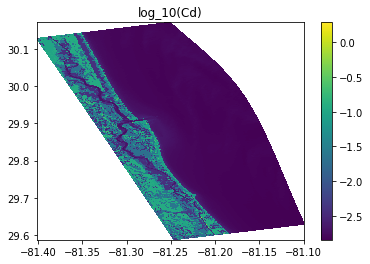

In [18]:
# look at the cd map
plt.pcolormesh(dsc.lon_rho.values,dsc.lat_rho.values,np.log10(cd))
plt.colorbar()
plt.title('log_10(Cd)')